In [1]:
import torchvision.models as models                   

import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
import math
warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [2]:
from numpy import asarray, percentile, tile
import torch.nn as nn
from scipy.ndimage import gaussian_filter
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
denormalize = transforms.Normalize(mean = [-0.485/0.229, -0.456/0.224, -0.406/0.225], std = [1/0.229, 1/0.224, 1/0.225] )
def image_converter(im):
    im_copy = im.cpu()
    
    im_copy = denormalize(im_copy.clone().detach()).numpy()
    im_copy = im_copy.transpose(1,2,0)
    im_copy = im_copy.clip(0, 1) 
    return im_copy

def layer_hook(act_dict, layer_name):
    def hook(module, input, output):
        act_dict[layer_name] = output
    return hook

In [3]:
def act_max(model, 
    input, 
    layer_activation, 
    layer_name, 
    unit, 
    steps=5, 
    alpha=torch.tensor(0.005),
    theta_decay=0.1,
    theta_every=4,
    theta_width=0.1,
    ):

    best_activation = -float('inf')
    best_img = input
    normalizer = torch.norm(input)
    layer_out = layer_activation[layer_name]
    # list(model.children())[-1].register_backward_hook(layer_hook(backward_layer_activation, first_layer))
    # b_layer_out = backward_layer_activation[first_layer]
    for k in range(steps):
        input.requires_grad_(True)
        input.retain_grad() 
        model.zero_grad()
        old_norm = torch.norm(input)
        # Propogate image
        model(input)

        # compute gradients
        layer_out[0][unit].backward(retain_graph=True)
        img_grad = input.grad
        #img_grad = b_layer_out[0]



        # Gradient Step
        input = torch.add(input, torch.mul(img_grad, alpha))

        #L2_Decay
        input = torch.mul(input, (1.0 - theta_decay))

        normalizer = (normalizer * (k+1) + torch.norm(input))/(k+2)

        new_norm = torch.norm(input)
        input = torch.mul(input, old_norm/new_norm)

        #assert(math.isclose(torch.norm(input), normalizer, rel_tol=1e-2))
        #Gaussian Blurr
        if k % theta_every is 0:
            temp = input.squeeze(0)
            temp = temp.detach().cpu().numpy()
            for channel in range(3):
                cimg = gaussian_filter(temp[channel], theta_width)
                temp[channel] = cimg
            temp = torch.from_numpy(temp).cuda()
            input = temp.unsqueeze(0)

        print('step: ', k, 'activation: ', layer_out[0][unit])
        if k % 10 == 0:
            final_image = image_converter(input.squeeze(0))
            #plt.imshow(final_image)
            #plt.show()
            print('step: ', k, 'activation: ', layer_out[0][unit])

        # Keep highest activation
        if layer_out[0][unit] > best_activation:
            best_activation = layer_out[0][unit]
            best_img = input
    return (best_activation, best_img)

In [4]:
def load_image(img_path, device=False):
    img = Image.open(img_path)
    img = img.resize((256, 256))
    img = img.convert('RGB')
    img = asarray(img).transpose(-1, 0, 1)
    img = img/255
    img = torch.from_numpy(img) 
    img = normalize(img)
    img = img.unsqueeze(0)
    img.requires_grad = True
    if device:
        img = img.type(torch.cuda.FloatTensor)
    else:
        img = img.type(torch.FloatTensor)
    return img


In [5]:
model = models.resnet50(pretrained = True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

model.eval().to(device)

Using cache found in C:\Users\neilh/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
# uris = [
#     'http://images.cocodataset.org/test-stuff2017/000000024309.jpg',
# ]
# uri = 'https://salient-imagenet.cs.umd.edu/feature_visualization/class_130/feature_484/images/0.jpg'
# input = utils.prepare_input_from_uri(uri).to(device)
#input = load_image('flamingo_image.jpg')
input1 = torch.rand(3, 256, 256, requires_grad=True)
input1 = input1.type(torch.FloatTensor)
input1 = input1.unsqueeze(0)
input2 = torch.rand(3, 256, 256, requires_grad=True)
input2 = input2.type(torch.FloatTensor)
input2 = input2.unsqueeze(0)
input3 = torch.rand(3, 256, 256, requires_grad=True)
input3 = input3.type(torch.FloatTensor)
input3 = input3.unsqueeze(0)

In [7]:
# result = resnet50(input)
# value = result.detach().numpy()
# k = max(value[0])
def layers_name_type(network):
    name_type_pair = [(key, value) for key, value in network.named_modules()]
    return name_type_pair


In [8]:
activation_dictionary = {}
# backward_activation_dictionary = {}
# print(layers_name_type(model)[-1])
layer_name = 'classifier_final'
first_layer_name = 'conv1'
list(model.children())[-1].register_forward_hook(layer_hook(layer_activation, layer_name))


('fc', Linear(in_features=2048, out_features=1000, bias=True))


In [9]:
steps = 100
#unit = list(value[0]).index(k)   
unit = 130               
alpha = torch.tensor(1) 
#input = torch.add(input, torch.norm(input, float('inf')), alpha = (-1)*0.1)   
input1 = input1.cuda()
input2 = input2.cuda()
input3 = input3.cuda()

In [10]:
acivation1, output1 = act_max(model=model,
                input=input1,
                forward_layer_activation = activation_dictionary,
                backward_layer_activation = activation_dictionary,
                layer_name = layer_name,
                unit=unit,
                steps=steps,
                alpha=alpha,
                )
# acivation2, output2 = act_max(model=model,
#                 input=input2,
#                 layer_activation=forward_activation_dictionary,
#                 layer_name=layer_name,
#                 unit=unit,
#                 steps=steps,
#                 alpha=alpha,
#                 )
# acivation3, output3 = act_max(model=model,
#                 input=input3,
#                 layer_activation=forward_activation_dictionary,
#                 layer_name=layer_name,
#                 unit=unit,
#                 steps=steps,
#                 alpha=alpha,
#                 )


KeyError: 'classifier_final'

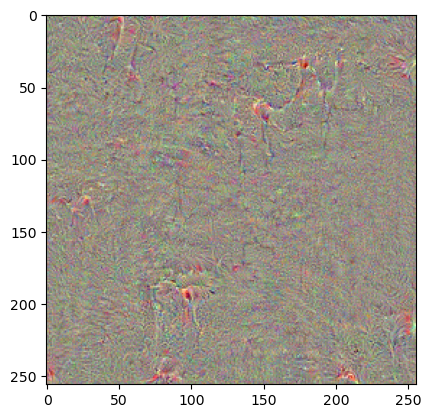

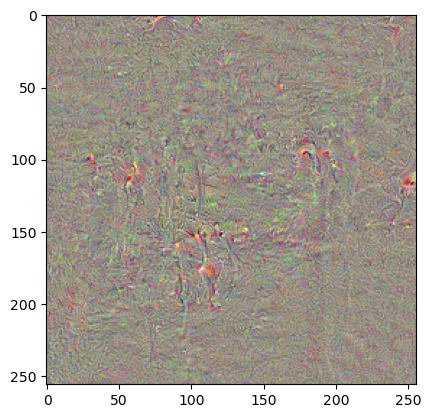

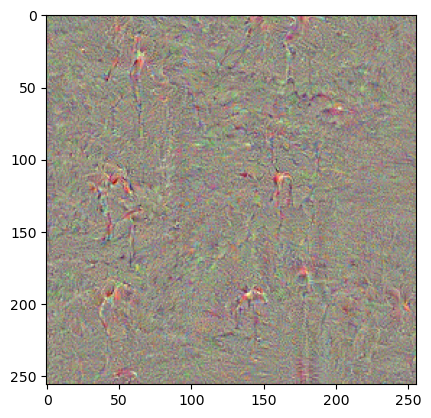

tensor(217.7321, device='cuda:0', grad_fn=<SelectBackward0>)


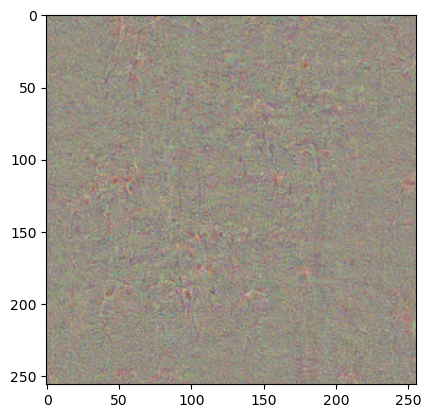

In [ ]:
# result = resnet50(output1)
# value = result.detach().numpy()
# k = max(value[0])
# index = list(value[0]).index(k)
# print(k)
# print(acivation)
# print(index)
# print(unit)
#ori = load_image('flamingo_image.jpg')
#ori = image_converter(ori.squeeze(0))
#plt.imshow(ori)
#plt.show()
#plt.imshow(abs(ori - final_image))
#plt.show()
#assert(unit == index)
final_image1 = image_converter(output1.squeeze(0))
plt.imshow(final_image1)
plt.show()
# final_image2 = image_converter(output2.squeeze(0))
# plt.imshow(final_image2)
# plt.show()
# final_image3 = image_converter(output3.squeeze(0))
# plt.imshow(final_image3)
# plt.show()
print(acivation1)
# avg_img = np.average(np.array((final_image1, final_image2, final_image3)))
# print(avg_img.shape)
# avg_img = torch.mul(torch.add(torch.add(output1.squeeze(0), output2.squeeze(0)), output3.squeeze(0)), 1/3)
# plt.imshow(image_converter(avg_img))
# plt.show()
